# Introduction to single-cell multi-view profiler (scMVP_regress)
In this introductory tutorial, we present the different tasks of a scMVP workflow
1. Loading the multi-omics data
2. Training the multi-view model
3. Retrieving the common latent space and imputed multi-omics values
4. Perform cell clustering and differential expression 
5. Visualize the common latent space and clustering with umap
6. The differential gene cluster identification
7. Linking CREs to gene clusters with partial least square regression

In [9]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import random
import torch

from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
from sklearn.metrics import r2_score
from sklearn.cross_decomposition import PLSRegression
## Visualizing the latent space with scanpy
import scanpy as sc
import anndata
import seaborn as sns

from scMVP.dataset import ATACDataset, geneDataset, SnareDemo
from scMVP.models import VAE
from scMVP.inference import UnsupervisedTrainer
from scMVP.inference import MultiPosterior, MultiTrainer
from scMVP.models.multi_vae import Multi_VAE

## Loading data

 loading the mouse brain dataset described in Song chen et al. (2019).

* Song chen, et al. "High-throughput sequencing of the transcriptome and chromatin accessibility in the same cell" Nat Biotechnol 37 (2019): 1452-1457. 

GEO data download url: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE126074

In [2]:
test_mode = False
n_epochs_all = None
show_plot = True


save_path = "dataset/snare_seq/"

    
dataset = SnareDemo("P0_BrainCortex",data_path=save_path)

[2020-09-24 18:06:58,021] INFO - scMVP.dataset.scMVP_dataloader | Preprocessing joint profiling dataset.
[2020-09-24 18:07:33,101] INFO - scMVP.dataset.scMVP_dataloader | Finished preprocessing dataset
[2020-09-24 18:07:33,399] INFO - scMVP.dataset.dataset | Remapping labels to [0,N]
[2020-09-24 18:07:33,401] INFO - scMVP.dataset.dataset | Remapping batch_indices to [0,N]
[2020-09-24 18:07:35,865] INFO - scMVP.dataset.dataset | Computing the library size for the new data
[2020-09-24 18:07:36,011] INFO - scMVP.dataset.dataset | Downsampled from 5081 to 5081 cells


## Manual data filtering 

In [4]:
def filter_dataset(dataset):
    high_count_genes = (dataset.X >0 ).sum(axis=0).ravel() > 0.01 * dataset.X.shape[0]
    dataset.update_genes(high_count_genes)
    dataset.subsample_genes(new_n_genes=10000)

    high_gene_count_cells = (dataset.X > 0 ).sum(axis=1).ravel() > 50
    extreme_gene_count_cells = (dataset.X).sum(axis=1).ravel() < 2000 # p0_2 multivae model
    high_gene_count_cells = np.logical_and(high_gene_count_cells,extreme_gene_count_cells)
    high_atac_cells = dataset.atac_expression.sum(axis=1) >= np.percentile(dataset.atac_expression.sum(axis=1), 1)
    
    
#     _tmp = np.logical_and(high_gene_count_cells, high_atac_cells)
#     high_exp_cells = dataset.X.sum(axis=1).ravel() +\
#                                dataset.atac_expression.sum(axis=1).ravel() > 750
    inds_to_keep = np.logical_and(high_atac_cells, high_gene_count_cells)
    dataset.update_cells(inds_to_keep)

    return dataset, inds_to_keep

if test_mode is False:
    dataset, inds_to_keep = filter_dataset(dataset)

[2020-09-24 18:15:27,175] INFO - scMVP.dataset.dataset | Downsampling from 7602 to 7602 genes
[2020-09-24 18:15:27,337] INFO - scMVP.dataset.dataset | Computing the library size for the new data
[2020-09-24 18:15:27,505] INFO - scMVP.dataset.dataset | Filtering non-expressing cells.
[2020-09-24 18:15:30,033] INFO - scMVP.dataset.dataset | Computing the library size for the new data
[2020-09-24 18:15:30,091] INFO - scMVP.dataset.dataset | Downsampled from 5081 to 5081 cells
[2020-09-24 18:15:30,109] INFO - scMVP.dataset.dataset | Not subsampling. Expecting: 1 < (new_n_genes=10000) <= self.nb_genes
[2020-09-24 18:15:33,857] INFO - scMVP.dataset.dataset | Computing the library size for the new data
[2020-09-24 18:15:33,914] INFO - scMVP.dataset.dataset | Downsampled from 5081 to 5030 cells


* __n_epochs__: Maximum number of epochs to train the model. If the likelihood change is small than a set threshold training will stop automatically. 
* __lr__: learning rate. Set to 0.001 here. 
* __use_batches__: If the value of true than batch information is used in the training. Here it is set to false because the cortex data only contains one batch. 
* __use_cuda__: Set to true to use CUDA (GPU required) 
* __n_centroids__: Set the number of cell types
* __n_alfa__: Set the weight of KL loss

In [5]:
n_epochs = 100 if n_epochs_all is None else n_epochs_all
lr = 1e-3
use_batches = False
use_cuda = True
n_centroids = 19
n_alfa = 1.0

## Pre-training
runing pre-train vae to initialize the Gaussian Mixture Model

In [6]:
train_model_path = "dataset/pretrain_model/"
pre_vae = VAE(dataset.nb_genes, n_batch=256)
pre_trainer = UnsupervisedTrainer(
    pre_vae,
    dataset,
    train_size=0.75,
    use_cuda=use_cuda,
    frequency=5,
)

is_test_pragram = False
if is_test_pragram:
    pre_trainer.train(n_epochs=n_epochs, lr=lr)
    torch.save(pre_trainer.model.state_dict(), '%s/scMVP_regress_GMM.pkl' % train_model_path)

if os.path.isfile('%s/scMVP_regress_GMM.pkl' % train_model_path):
    pre_trainer.model.load_state_dict(torch.load('%s/scMVP_regress_GMM.pkl' % train_model_path))
    pre_trainer.model.eval()
else:
    pre_trainer.train(n_epochs=n_epochs, lr=lr)
    torch.save(pre_trainer.model.state_dict(), '%s/scMVP_regress_GMM.pkl' % train_model_path)

# pretrainer_posterior:
full = pre_trainer.create_posterior(pre_trainer.model, dataset, indices=np.arange(len(dataset)))
latent, batch_indices, labels = full.sequential().get_latent()
batch_indices = batch_indices.ravel()
imputed_values = full.sequential().imputation()

sample_latents = torch.tensor([])
samples = torch.tensor([])
sample_labels = torch.tensor([])
for tensors_list in range(int(len(imputed_values)/256)+1):
    if tensors_list == range(int(len(imputed_values)/256)):
        x = torch.zeros((256,len(imputed_values[0])))
        x[0:len(x)-256*tensors_list,:] = torch.tensor(imputed_values[tensors_list * 256:len(imputed_values), :])
        y = torch.zeros((256))
        y[0:len(x)-256*tensors_list,:]  = torch.tensor(dataset.labels[tensors_list * 256:len(imputed_values)].astype(int))
        temp_samples = pre_trainer.model.get_latents(x,y)
        for temp_sample in temp_samples:
            sample_latents = torch.cat((sample_latents, temp_sample[0:len(x)-256*tensors_list,:].float()))
    temp_samples = pre_trainer.model.get_latents(
        x=torch.tensor(imputed_values[tensors_list * 256:(1 + tensors_list) * 256, :]),
        y=torch.tensor(dataset.labels[tensors_list * 256:(1 + tensors_list) * 256].astype(int)))
    for temp_sample in temp_samples:
        sample_latents = torch.cat((sample_latents, temp_sample.float()))
        
# visulization
prior_adata = anndata.AnnData(X=dataset.X)
prior_adata.obsm["X_multi_vi"] = sample_latents.detach().numpy()
prior_adata.obs['cell_type'] = torch.tensor(dataset.labels[0:len(sample_latents)].astype(int))
sc.pp.neighbors(prior_adata, use_rep="X_multi_vi", n_neighbors=15)
sc.tl.umap(prior_adata, min_dist=0.1)
fig, ax = plt.subplots(figsize=(7, 6))
sc.pl.umap(prior_adata, color=["cell_type"], ax=ax, show=show_plot)

sample_latents = latent

<All keys matched successfully>

VAE(
  (z_encoder): Encoder(
    (encoder): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
          (0): Linear(in_features=7602, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (mean_encoder): Linear(in_features=128, out_features=10, bias=True)
    (var_encoder): Linear(in_features=128, out_features=10, bias=True)
  )
  (l_encoder): Encoder(
    (encoder): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
          (0): Linear(in_features=7602, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (mean_encoder): Linear(in_features=128, out_features=1, bias=True)
    (var_encoder): Linear(in_features=128

/home/fusl/miniconda2/envs/scMVP/lib/python3.7/site-packages/anndata-0.7.4-py3.7.egg/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'cell_type' as categorical


# Training scMVP
We now create the scMVP model and the trainer object.

If a pre-trained model already exist in your path, then load the same model rather than re-training it. This is particularly useful for large datasets.

In [7]:
multi_vae = Multi_VAE(dataset.nb_genes, len(dataset.atac_names), n_batch=256, n_centroids=n_centroids, n_alfa = n_alfa, mode="mm-vae") # should provide ATAC num, alfa, mode and loss type

trainer = MultiTrainer(
    multi_vae,
    dataset,
    train_size=0.75,
    use_cuda=use_cuda,
    frequency=5,
)

clust_index_gmm = trainer.model.init_gmm_params(sample_latents)
# gmm clustering
prior_adata.obs['cell_type'] = torch.tensor(clust_index_gmm.reshape(-1,1))
sc.pp.neighbors(prior_adata, use_rep="X_multi_vi", n_neighbors=15)
sc.tl.umap(prior_adata, min_dist=0.1)

is_test_pragram = False
if is_test_pragram:
    trainer.train(n_epochs=n_epochs, lr=lr)
    torch.save(trainer.model.state_dict(), '%s/scMVP_regress_mmvae.pkl' % train_model_path)

if os.path.isfile('%s/scMVP_regress_mmvae.pkl' % train_model_path):
    trainer.model.load_state_dict(torch.load('%s/scMVP_regress_mmvae.pkl' % train_model_path))
    trainer.model.eval()
else:
    trainer.train(n_epochs=n_epochs, lr=lr)
    torch.save(trainer.model.state_dict(), '%s/scMVP_regress_mmvae.pkl' % train_model_path)

<All keys matched successfully>

Multi_VAE(
  (RNA_encoder): Encoder(
    (encoder): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
          (0): Linear(in_features=7602, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (mean_encoder): Linear(in_features=128, out_features=10, bias=True)
    (var_encoder): Linear(in_features=128, out_features=10, bias=True)
  )
  (ATAC_encoder): Encoder(
    (encoder): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
          (0): Linear(in_features=199430, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (mean_encoder): Linear(in_features=128, out_features=10, bias=True)
    (var_encoder): Linear(i

Plotting the likelihood change across the n epochs of training: blue for training error and orange for testing error.**

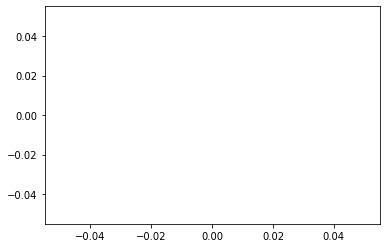

In [10]:
elbo_train_set = trainer.history["elbo_train_set"]
elbo_test_set = trainer.history["elbo_test_set"]
x = np.linspace(0, 500, (len(elbo_train_set)))
plt.plot(x, elbo_train_set)
plt.plot(x, elbo_test_set)
plt.show()

Query the imputed values via the `imputation` method of the posterior object and get common latent embedding. 

In [11]:
full = trainer.create_posterior(trainer.model, dataset, indices=np.arange(len(dataset)),type_class=MultiPosterior)
imputed_values = full.sequential().imputation()
sample_latents = torch.tensor([])
sample_labels = torch.tensor([])
rna_imputation = imputed_values[0]
atac_imputation = imputed_values[3]
temp_label = []
sample_latents = torch.tensor([])
samples = torch.tensor([])
sample_labels = torch.tensor([])
if len(imputed_values) >= 3:
    temp_label = imputed_values[2]
for tensors_list in range(int(len(imputed_values[0])/256)+1):
    if temp_label.any():
        temp_samples = trainer.model.get_latents(x_rna=torch.tensor(rna_imputation[tensors_list*256:(1+tensors_list)*256,:]),
                                                x_atac=torch.tensor(atac_imputation[tensors_list*256:(1+tensors_list)*256,:]),
                                                y=torch.tensor(temp_label[tensors_list*256:(1+tensors_list)*256])) 
    else:
        temp_samples = trainer.model.get_latents(x_rna=torch.tensor(rna_imputation[tensors_list*256:(1+tensors_list)*256,:]),
                                                x_atac=torch.tensor(atac_imputation[tensors_list*256:(1+tensors_list)*256,:]),
                                                y=torch.tensor(np.zeros(256))) 
    for temp_sample in temp_samples:
        #sample_latents = torch.cat((sample_latents, temp_sample[2].float()))
        sample_latents = torch.cat((sample_latents, temp_sample[0][0].float()))
        sample_labels = torch.cat((sample_labels, torch.tensor(temp_label[tensors_list*256:(1+tensors_list)*256]).float()))


## Cell clustering
Cell clustering and merging the rare clusters which less than 10 cells

In [12]:
clust_index_gmm = trainer.model.init_gmm_params(sample_latents.detach().numpy())
gmm_clus_index = clust_index_gmm.reshape(-1,1)
for i in range(len(np.unique(gmm_clus_index))):
    if len(gmm_clus_index[gmm_clus_index == i]) <= 10:
        for j in range(len(np.unique(gmm_clus_index))):
            if len(gmm_clus_index[gmm_clus_index == j]) > 100:
                gmm_clus_index[gmm_clus_index == i] = j
                break
unique_gmm_clus_index = np.unique(gmm_clus_index)
for i in range(len(unique_gmm_clus_index)):
    gmm_clus_index[gmm_clus_index == unique_gmm_clus_index[i]] = i

- Visualizing common latent embedding and cell clustering by scMVP

/home/fusl/miniconda2/envs/scMVP/lib/python3.7/site-packages/anndata-0.7.4-py3.7.egg/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'cell_type' as categorical


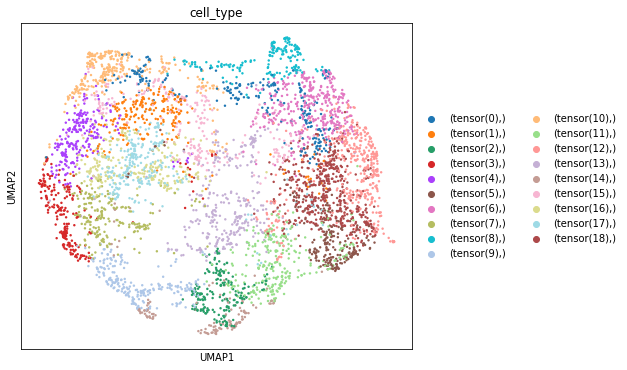

/home/fusl/miniconda2/envs/scMVP/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
/home/fusl/miniconda2/envs/scMVP/lib/python3.7/site-packages/anndata-0.7.4-py3.7.egg/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'cell_type' as categorical


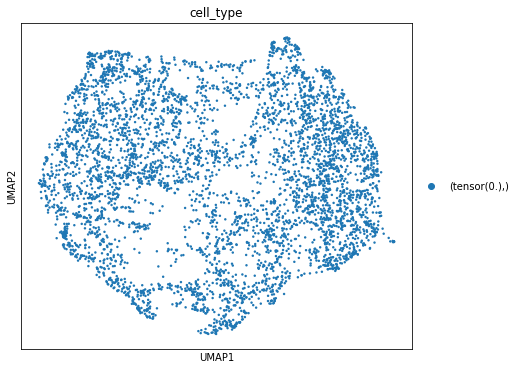

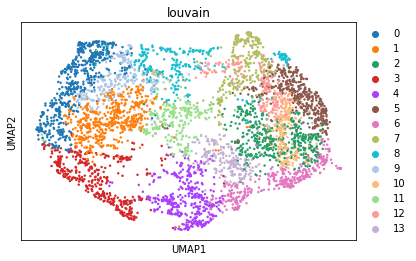

In [13]:
posterior_adata = anndata.AnnData(X=rna_imputation)
posterior_adata.obsm["X_multi_vi"] = sample_latents.detach().numpy()
posterior_adata.obs['cell_type'] = torch.tensor(clust_index_gmm.reshape(-1,1))
sc.pp.neighbors(posterior_adata, use_rep="X_multi_vi", n_neighbors=15)
sc.tl.umap(posterior_adata, min_dist=0.1)
fig, ax = plt.subplots(figsize=(7, 6))
sc.pl.umap(posterior_adata, color=["cell_type"], ax=ax, show=show_plot)
# imputation labels
posterior_adata.obs['cell_type'] = torch.tensor(sample_labels.reshape(-1,1))
sc.pp.neighbors(posterior_adata, use_rep="X_multi_vi", n_neighbors=15)
sc.tl.umap(posterior_adata, min_dist=0.1)
fig, ax = plt.subplots(figsize=(7, 6))
sc.pl.umap(posterior_adata, color=["cell_type"], ax=ax, show=show_plot)
sc.tl.louvain(posterior_adata)
sc.pl.umap(posterior_adata, color=['louvain'])

## Differential gene analysis
Identify differential genes in each cluster.

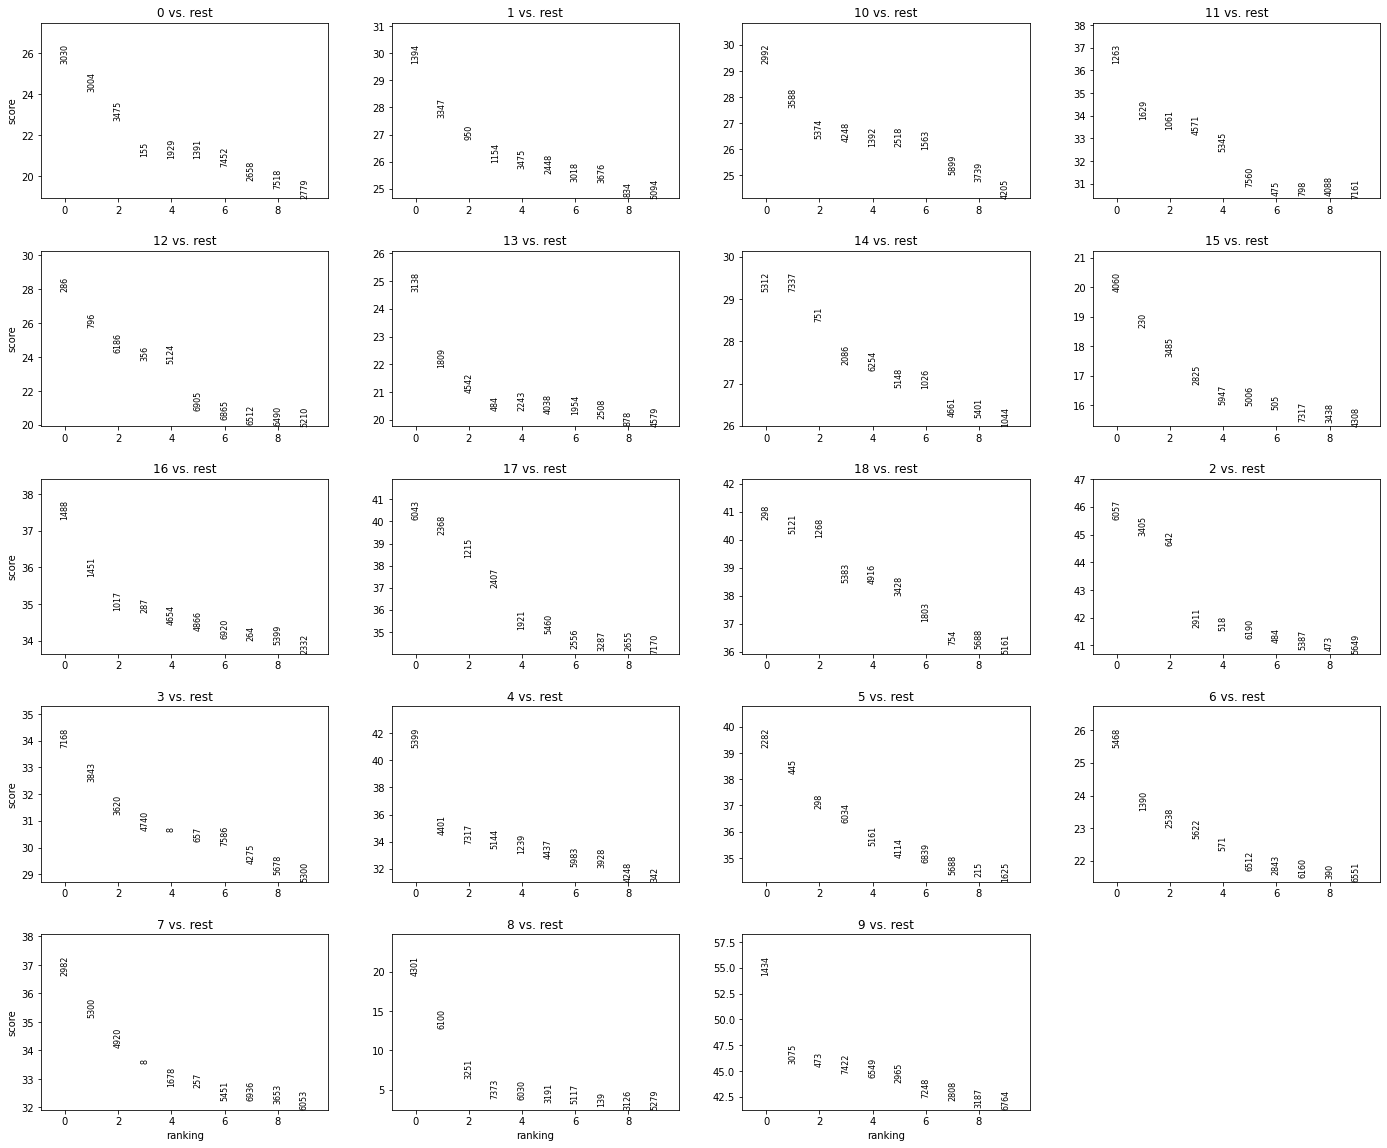

In [14]:
posterior_adata.obs['louvain'] = pd.Categorical((gmm_clus_index.T)[0].astype(np.str))
sc.tl.rank_genes_groups(posterior_adata, 'louvain')
sc.pl.rank_genes_groups(posterior_adata, n_genes=10, sharey=False)
diff_top_gene_set = posterior_adata.uns['rank_genes_groups']
diff_top_gene_set = (diff_top_gene_set['names'])
diff_top_gene_set = diff_top_gene_set[0:50]

diff_top_gene_pvalue_set = posterior_adata.uns['rank_genes_groups']
diff_top_gene_pvalue_set = (diff_top_gene_pvalue_set['pvals_adj'])
diff_top_gene_pvalue_set = diff_top_gene_pvalue_set[0:50]

diff_top_gene_foldchange_set = posterior_adata.uns['rank_genes_groups']
diff_top_gene_foldchange_set = (diff_top_gene_foldchange_set['logfoldchanges'])
diff_top_gene_foldchange_set = diff_top_gene_foldchange_set[0:50]

diff_top_gene_matrix = np.array([])
diff_top_gene_pvalue_matrix = np.array([])
diff_top_gene_foldchange_matrix = np.array([])
for i in range(len(diff_top_gene_set.dtype.descr)):
    if i == 0:
        diff_top_gene_matrix = diff_top_gene_set[str(i)].astype(np.int32)
        diff_top_gene_pvalue_matrix = diff_top_gene_pvalue_set[str(i)].astype(np.float)
        diff_top_gene_foldchange_matrix = diff_top_gene_foldchange_set[str(i)].astype(np.float)
    else:
        diff_top_gene_matrix = np.vstack((diff_top_gene_matrix,diff_top_gene_set[str(i)].astype(np.int32)))
        diff_top_gene_pvalue_matrix = np.vstack((diff_top_gene_pvalue_matrix, diff_top_gene_pvalue_set[str(i)].astype(np.float)))
        diff_top_gene_foldchange_matrix = np.vstack(
            (diff_top_gene_foldchange_matrix, diff_top_gene_foldchange_set[str(i)].astype(np.float)))
diff_top_gene_unique = np.unique(diff_top_gene_matrix.flatten())

## differential ATAC peaks analysis

- first perform peaks knn aggregation 

In [15]:
atac_expression = atac_imputation.T
atac_name = dataset.atac_names
cell_name = dataset.barcodes
knn_matrix = posterior_adata.uns['neighbors']
knn_matrix = knn_matrix['distances']
cluster_ID = posterior_adata.obs['louvain'].values
cluster_ID_unique = np.unique(cluster_ID)
is_cluster_dataset = False
if is_cluster_dataset:
    cluster_ID_index = cluster_ID == cluster_ID_unique[0]
    knn_cluster_matrix = knn_matrix[np.ix_(cluster_ID_index, cluster_ID_index)].A
    rank_knn = np.argpartition(knn_cluster_matrix, -3)[:, -3:]
    atac_cluster_expression = atac_expression[:, cluster_ID_index]
    for i in range(np.size(atac_cluster_expression, 1)):
        atac_cluster_expression[:, i] += np.sum(atac_cluster_expression[:, rank_knn[i, :]], axis=1)
    atac_cluster_expression[atac_cluster_expression > 1] = 1
else:
    for i in range(len(cluster_ID_unique)):
        cluster_ID_index = cluster_ID == cluster_ID_unique[i]
        knn_cluster_matrix = knn_matrix[np.ix_(cluster_ID_index, cluster_ID_index)].A
        rank_knn = np.argpartition(knn_cluster_matrix, -3)[:, -3:]
        atac_cluster_expression = atac_expression[:, cluster_ID_index]
        for j in range(np.size(atac_cluster_expression, 1)):
            atac_cluster_expression[:, j] += np.sum(atac_cluster_expression[:, rank_knn[j, :]], axis=1)
        atac_cluster_expression[atac_cluster_expression > 1] = 1
        atac_expression[:,cluster_ID_index] = atac_cluster_expression


/home/fusl/miniconda2/envs/scMVP/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  """


- Get differential peaks in each cell cluster

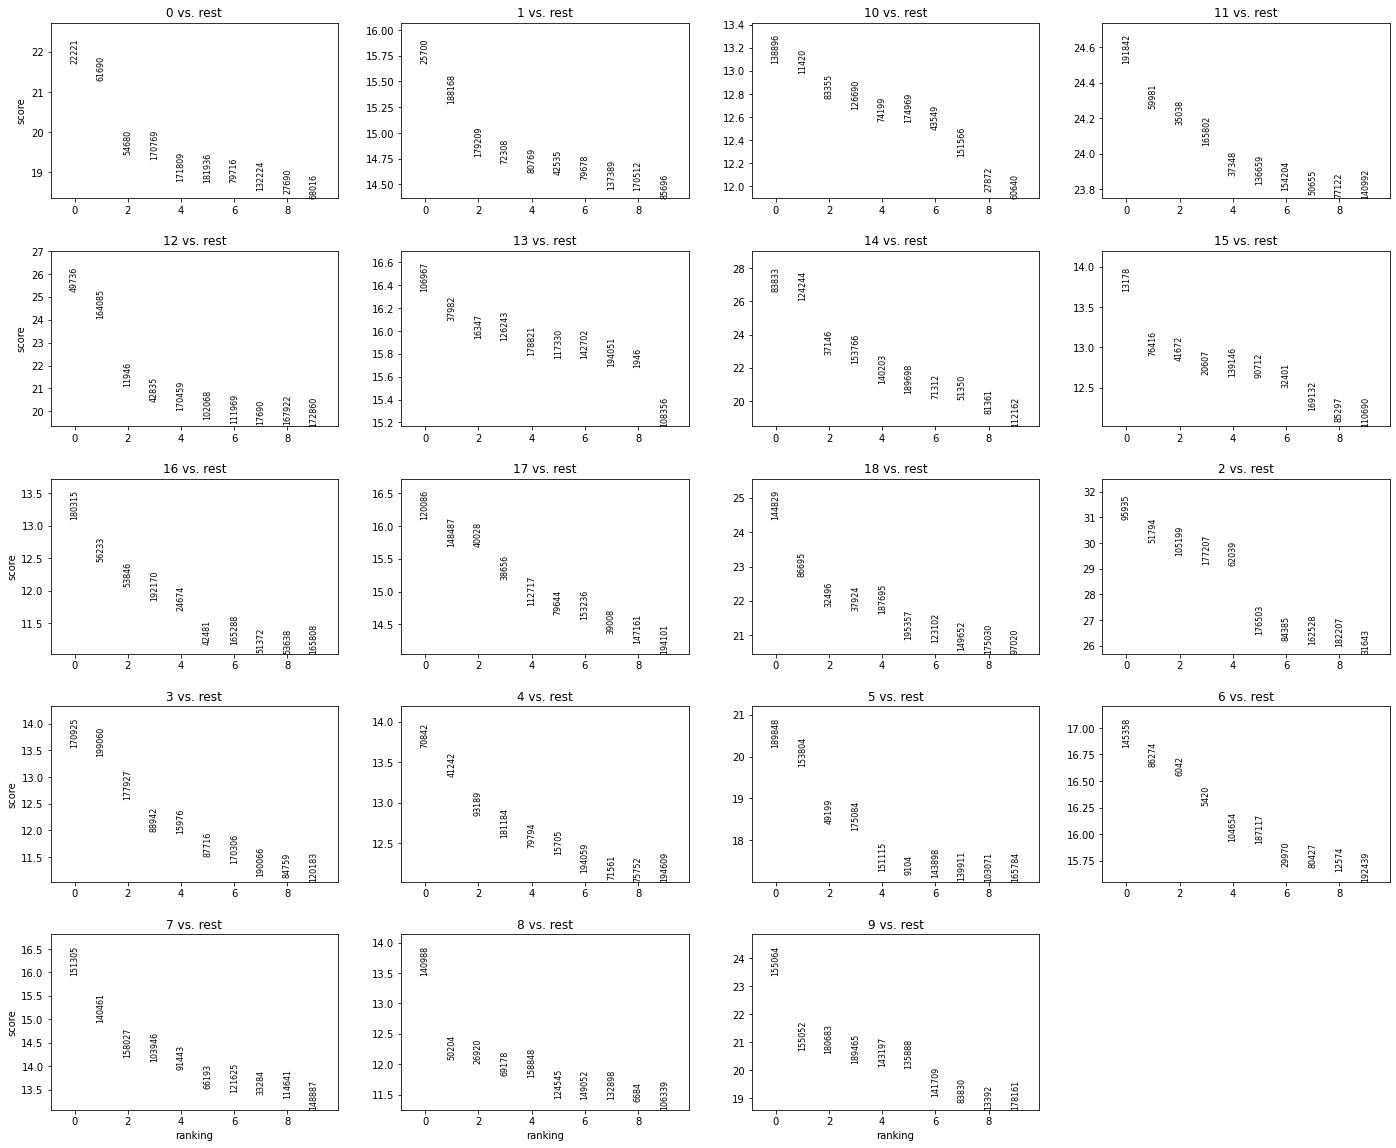

In [16]:
atac_posterior_adata = anndata.AnnData(X=atac_expression.T)
atac_posterior_adata.obs['louvain'] = posterior_adata.obs['louvain']
sc.tl.rank_genes_groups(atac_posterior_adata, 'louvain',n_genes=1000)
sc.pl.rank_genes_groups(atac_posterior_adata, n_genes=10, sharey=False)
atac_diff_top_gene_set = atac_posterior_adata.uns['rank_genes_groups']
atac_diff_top_gene_set = (atac_diff_top_gene_set['names'])
atac_diff_top_gene_pvalue_set = atac_posterior_adata.uns['rank_genes_groups']
atac_diff_top_gene_pvalue_set = (atac_diff_top_gene_pvalue_set['pvals_adj'])
atac_diff_top_gene_foldchange_set = atac_posterior_adata.uns['rank_genes_groups']
atac_diff_top_gene_foldchange_set = (atac_diff_top_gene_foldchange_set['logfoldchanges'])


# Differential gene module inference

[2020-09-24 19:04:49,102] INFO - scMVP.dataset.geneDataset | Preprocessing dataset
[2020-09-24 19:04:49,288] INFO - scMVP.dataset.geneDataset | Finished preprocessing dataset
[2020-09-24 19:04:49,349] INFO - scMVP.dataset.dataset | Remapping labels to [0,N]
[2020-09-24 19:04:49,351] INFO - scMVP.dataset.dataset | Remapping batch_indices to [0,N]
[2020-09-24 19:04:49,409] INFO - scMVP.dataset.dataset | Computing the library size for the new data
[2020-09-24 19:04:49,469] INFO - scMVP.dataset.dataset | Downsampled from 7602 to 7602 cells


<All keys matched successfully>

VAE(
  (z_encoder): Encoder(
    (encoder): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
          (0): Linear(in_features=5030, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (mean_encoder): Linear(in_features=128, out_features=10, bias=True)
    (var_encoder): Linear(in_features=128, out_features=10, bias=True)
  )
  (l_encoder): Encoder(
    (encoder): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
          (0): Linear(in_features=5030, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (mean_encoder): Linear(in_features=128, out_features=1, bias=True)
    (var_encoder): Linear(in_features=128

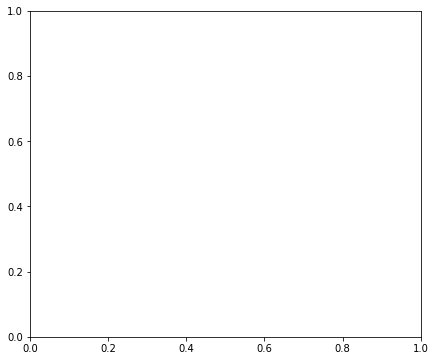

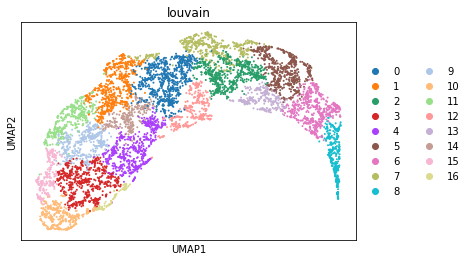

In [17]:
gene_expression = rna_imputation.T
for i in range(len(gene_expression)):
    gene_expression[i, :] = np.log1p(gene_expression[i, :]) / np.log1p(np.max(gene_expression[i, :])) + 0.0001
gene_exp_data = geneDataset(gene_expression, dataset.gene_names, dataset.barcodes)
gene_exp_vae = VAE(gene_exp_data.nb_genes, n_batch=256)
gene_exp_trainer = UnsupervisedTrainer(
    gene_exp_vae,
    gene_exp_data,
    train_size=0.75,
    use_cuda=use_cuda,
    frequency=5,
)
is_test_pragram = False

if is_test_pragram:
    gene_exp_trainer.train(n_epochs=n_epochs, lr=lr)
    torch.save(gene_exp_trainer.model.state_dict(), '%s/scMVP_regress_vae.pkl' % train_model_path)

if os.path.isfile('%s/scMVP_regress_vae.pkl' % train_model_path):
    gene_exp_trainer.model.load_state_dict(torch.load('%s/scMVP_regress_vae.pkl' % train_model_path))
    gene_exp_trainer.model.eval()
else:
    gene_exp_trainer.train(n_epochs=n_epochs, lr=lr)
    torch.save(gene_exp_trainer.model.state_dict(), '%s/scMVP_regress_vae.pkl' % train_model_path)
    
# visulization
full = gene_exp_trainer.create_posterior(gene_exp_trainer.model, gene_exp_data, indices=np.arange(len(gene_exp_data)))
latent, batch_indices, labels = full.sequential().get_latent()
batch_indices = batch_indices.ravel()
imputed_values = full.sequential().imputation()
gene_exp_adata = anndata.AnnData(X=gene_exp_data.X)
gene_exp_adata.obsm["X_multi_vi"] = latent
sc.pp.neighbors(gene_exp_adata, use_rep="X_multi_vi", n_neighbors=15)
sc.tl.umap(gene_exp_adata, min_dist=0.1)
fig, ax = plt.subplots(figsize=(7, 6))
sc.tl.louvain(gene_exp_adata)
sc.pl.umap(gene_exp_adata, color=['louvain'])

# diff gene cluster
cell_clu_index = posterior_adata.obs['louvain'].values.astype(np.int32)
gene_clu_index = gene_exp_adata.obs['louvain'].values.astype(np.int32)
diff_rank_gene_clu_index = gene_clu_index[diff_top_gene_unique]
gene_clu_index_unique, gene_clu_index_counts = np.unique(gene_clu_index,return_counts = True)
diff_rank_gene_clu_index_unique, diff_rank_gene_clu_index_counts = np.unique(diff_rank_gene_clu_index,return_counts = True)
diff_rank_gene_clu_filter = np.where(diff_rank_gene_clu_index_counts >= 0.04*np.sum(diff_rank_gene_clu_index_counts))
diff_rank_gene_clu_filter_matrix = np.zeros((2,len(diff_rank_gene_clu_filter[0])))
diff_rank_gene_clu_filter_matrix[0,:] = diff_rank_gene_clu_index_unique[diff_rank_gene_clu_filter[0]]
diff_rank_gene_clu_filter_matrix[1,:] = diff_rank_gene_clu_index_counts[diff_rank_gene_clu_filter[0]]

## CRE regress for differential gene module using PLS
**Notice: regression step will take serveral hours corresponds to size of dataset.**

PLSRegression(copy=True, max_iter=500, n_components=40, scale=False, tol=1e-06)

PLSRegression(copy=True, max_iter=500, n_components=40, scale=False, tol=1e-06)

PLSRegression(copy=True, max_iter=500, n_components=40, scale=False, tol=1e-06)

PLSRegression(copy=True, max_iter=500, n_components=40, scale=False, tol=1e-06)

PLSRegression(copy=True, max_iter=500, n_components=40, scale=False, tol=1e-06)

PLSRegression(copy=True, max_iter=500, n_components=40, scale=False, tol=1e-06)

PLSRegression(copy=True, max_iter=500, n_components=40, scale=False, tol=1e-06)

PLSRegression(copy=True, max_iter=500, n_components=40, scale=False, tol=1e-06)

PLSRegression(copy=True, max_iter=500, n_components=40, scale=False, tol=1e-06)

PLSRegression(copy=True, max_iter=500, n_components=40, scale=False, tol=1e-06)

PLSRegression(copy=True, max_iter=500, n_components=40, scale=False, tol=1e-06)

<AxesSubplot:xlabel='clusters', ylabel='R2'>

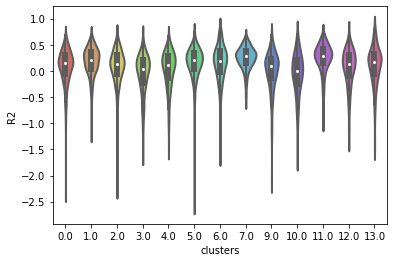

<AxesSubplot:xlabel='clusters', ylabel='corr'>

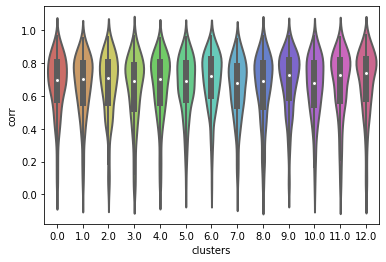

In [18]:
gene_cluster_ID = gene_exp_adata.obs['louvain'].values
gene_cluster_specific_atac = None
gene_cluster_ID_unique = diff_rank_gene_clu_filter_matrix[0,:].astype(np.int32) # for the filtered diff gene set
n_components = 40
selected_feature_R2 = None
selected_feature_R2_index = None
PLS_predict_gene_exp_corr = np.array([])
PLS_predict_gene_exp_corr_index = np.array([])

for i in range(len(gene_cluster_ID_unique)):
    x_train, x_test, y_train, y_test = train_test_split(atac_expression.T,
                                                        gene_expression[
                                                        gene_cluster_ID.astype(np.int32) == gene_cluster_ID_unique[
                                                            i].astype(np.int32), :].T,
                                                        test_size=0.1,
                                                        random_state=33)
    pls = PLSRegression(n_components=n_components, scale=False)
    pls.fit(x_train, y_train)  
    y_pls_predict = pls.predict(x_test)
    test_pls_error = np.mean((y_pls_predict - y_test) ** 2, axis=0)
    test_pls_R2 = np.zeros(y_test.shape[0])
    for j in range(y_test.shape[0]):
        test_pls_R2[j] = np.corrcoef(y_pls_predict[j,:], y_test[j,:])[0,1]
    PLS_predict_gene_exp_corr = np.append(PLS_predict_gene_exp_corr,test_pls_R2)
    PLS_predict_gene_exp_corr_index = np.append(PLS_predict_gene_exp_corr_index,i*np.ones(len(test_pls_R2)).astype(np.int))
   
    test_pls_error = np.mean((y_pls_predict - y_test) ** 2, axis=0)
    indices_pls = np.argsort(np.abs(pls.coef_).T)[:, ::-1].T
    selected_pls_feature_index = indices_pls[0:5000, :]
     # R2
    for j in range(np.size(y_pls_predict,axis=1)):
        if selected_feature_R2 is None:
            selected_feature_R2 = np.array([r2_score(y_pls_predict[:,j],y_test[:,j])])
            selected_feature_R2_index= gene_cluster_ID_unique[i]
        else:
            selected_feature_R2 = np.hstack((selected_feature_R2,np.array([r2_score(y_pls_predict[:,j], y_test[:,j])])))
            selected_feature_R2_index = np.append(selected_feature_R2_index,gene_cluster_ID_unique[i])
            
# visualizing correlation between the PLS regression and gene expression
R2_df = pd.DataFrame(np.vstack((selected_feature_R2_index.flatten(),selected_feature_R2.flatten())).T,columns=['clusters', 'R2'])
sns.violinplot(x="clusters", y="R2", data=R2_df,
            linewidth = 2,   
            width = 0.8,     
            palette = 'hls', 
            scale = 'area',  
            gridsize = 50,   
            inner = 'box'
           )
plt.show()
R2_df = pd.DataFrame(np.vstack((PLS_predict_gene_exp_corr_index,np.abs(PLS_predict_gene_exp_corr))).T,columns=['clusters', 'corr'])
sns.violinplot(x="clusters", y="corr", data=R2_df,
            linewidth = 2,   
            width = 0.8,     
            palette = 'hls', 
            scale = 'area',  
            gridsize = 50,   
            inner = 'box'
           )
plt.show()